# Algorithm for dog breed identification

In this notebook we construct a CNN from scratch to classify dog breeds. 

We also construct a human face detector (load a pre-trained model) and a dog detector (use a pre-trained vgg16 model), which are used later in our final function to predict for any user-supplied image.  If a dog is detected in the image, it will provide an estimate of the dog's breed.  If a human is detected, it will provide an estimate of the dog breed that is most resembling.  


Make sure the human and dog datasets have been downloaded and put in the correct location (see the README file) before running this notebook

In [40]:
from PIL import Image
import torchvision.transforms as transforms
from PIL import ImageFile
import torch
import torchvision.models as models

from src.models import predict_model


from torchvision import datasets
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

import numpy as np
from glob import glob
import os
import random

import cv2                
import matplotlib.pyplot as plt                        
%matplotlib inline         

In [3]:
TRAIN_DATA_PATH = "../data/raw/dogImages/train"
VALIDATION_DATA_PATH = "../data/raw/dogImages/valid"
TEST_DATA_PATH = "../data/raw/dogImages/test"

In [4]:
# check if CUDA is available
use_cuda = torch.cuda.is_available()

In [5]:
random.seed(12)

# load filenames for human and dog images
human_files = np.array(glob("../data/raw/lfw/*/*"))
dog_files = np.array(glob("../data/raw/dogImages/*/*/*"))
random.shuffle(human_files)
random.shuffle(dog_files)

# print number of images in each dataset
print('There are %d total human images.' % len(human_files))
print('There are %d total dog images.' % len(dog_files))

There are 13233 total human images.
There are 8351 total dog images.


In [6]:
human_files

array(['../data/raw/lfw\\Nicole_Hiltz\\Nicole_Hiltz_0001.jpg',
       '../data/raw/lfw\\Donald_Rumsfeld\\Donald_Rumsfeld_0020.jpg',
       '../data/raw/lfw\\Robbie_Coltrane\\Robbie_Coltrane_0001.jpg', ...,
       '../data/raw/lfw\\Robbie_Williams\\Robbie_Williams_0003.jpg',
       '../data/raw/lfw\\George_W_Bush\\George_W_Bush_0464.jpg',
       '../data/raw/lfw\\Lars_Von_Trier\\Lars_Von_Trier_0001.jpg'],
      dtype='<U96')

In [7]:
breeds = [x.split('/')[3].split("\\")[3][:-10] for x in dog_files]
breeds = np.unique(breeds)
print(f"There are {len(breeds)} breeds in total\n")
print(f"example breeds: \n{breeds[:5]}")

There are 133 breeds in total

example breeds: 
['Affenpinscher' 'Afghan_hound' 'Airedale_terrier' 'Akita'
 'Alaskan_malamute']


## Detect Humans

Here we use OpenCV's implementation of [Haar feature-based cascade classifiers](http://docs.opencv.org/trunk/d7/d8b/tutorial_py_face_detection.html) to detect human faces in images.  

OpenCV provides many pre-trained face detectors, stored as XML files on [github](https://github.com/opencv/opencv/tree/master/data/haarcascades). 

When installing `opencv-python` into our virtual environment `dog_breed`, the face detector is automatically downloaded. For me, it went into the location `'C:\ProgramData\Anaconda3\envs\dog_breed\Lib\site-packages\cv2\data\haarcascade_frontalface_alt.xml'`. If the code below doens't work and it cannot find that xml file, try to locate where exactly the file is for you and insert the correct path

Number of faces detected: 1


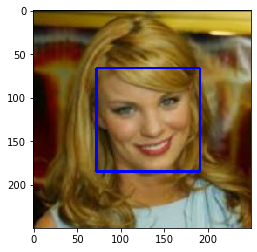

In [8]:
# extract pre-trained face detector
face_cascade = cv2.CascadeClassifier('C:\ProgramData\Anaconda3\envs\dog_breed\Lib\site-packages\cv2\data\haarcascade_frontalface_alt.xml')

# load color (BGR) image
img = cv2.imread(human_files[0])
# convert BGR image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# find faces in image
faces = face_cascade.detectMultiScale(gray)

# print number of faces detected in the image
print('Number of faces detected:', len(faces))

# get bounding box for each detected face
for (x,y,w,h) in faces:
    # add bounding box to color image
    cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    
# convert BGR image to RGB for plotting
cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# display the image, along with bounding box
plt.imshow(cv_rgb)
plt.show()

Before using any of the face detectors, it is standard procedure to convert the images to grayscale.  The `detectMultiScale` function executes the classifier stored in `face_cascade` and takes the grayscale image as a parameter.  

In the above code, `faces` is a numpy array of detected faces, where each row corresponds to a detected face.  Each detected face is a 1D array with four entries that specifies the bounding box of the detected face.  The first two entries in the array (extracted in the above code as `x` and `y`) specify the horizontal and vertical positions of the top left corner of the bounding box.  The last two entries in the array (extracted here as `w` and `h`) specify the width and height of the box.

#### Human Face Detector

We can use this procedure to write a function that returns `True` if a human face is detected in an image and `False` otherwise.  This function, aptly named `face_detector`, takes a string-valued file path to an image as input

In [9]:
# returns "True" if face is detected in image stored at img_path
def face_detector(img_path):
    img = cv2.imread(img_path)  # read image
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)  #c onvert to grey
    faces = face_cascade.detectMultiScale(gray)  # detect faces
    return len(faces) > 0  # if faces empty, no face found (return False). If non-empty return True.

#### Try out the human face detector

We can ask ourselves the following questions:
- What percentage of the first 100 images in `human_files` have a detected human face?  
- What percentage of the first 100 images in `dog_files` have a detected human face? 

Ideally, we would like 100% of human images with a detected face and 0% of dog images with a detected face. Unfortunately it's not that perfect, but it's decent enough as can be seen below

In [10]:
# pick some human and dog files to test our face detector on
human_files_short = human_files[:100]
dog_files_short = dog_files[:100]

# Test the performance of the face_detector algorithm 
human_count = 0
dog_count = 0

for ii, human_path in enumerate(human_files_short):
    human_count += face_detector(human_path)
    dog_count += face_detector(dog_files_short[ii])
    
print(f'Faces were detected in {human_count}% of our human images, and {dog_count}% of our dog images')

Faces were detected in 98% of our human images, and 11% of our dog images


## Detect Dogs

Here we use a [pre-trained model](http://pytorch.org/docs/master/torchvision/models.html) to detect dogs in images.  

#### Obtain Pre-trained VGG-16 Model

The code cell below downloads the VGG-16 model, along with weights that have been trained on [ImageNet](http://www.image-net.org/), a very large, popular dataset used for image classification and other vision tasks.  ImageNet contains over 10 million URLs, each linking to an image containing an object from one of [1000 categories](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a).  

In [11]:
# define VGG16 model
VGG16 = models.vgg16(pretrained=True)

# move model to GPU if CUDA is available
if use_cuda:
    VGG16 = VGG16.cuda()

Given an image, this pre-trained VGG-16 model returns a prediction (derived from the 1000 possible categories in ImageNet) for the object that is contained in the image.

###  Making Predictions with a Pre-trained Model

Here we create a function that accepts a path to an image (such as `'dogImages/train/001.Affenpinscher/Affenpinscher_00001.jpg'`) as input and returns the index corresponding to the ImageNet class that is predicted by the pre-trained VGG-16 model.  The output should always be an integer between in [0, 999]

In [12]:
ImageFile.LOAD_TRUNCATED_IMAGES = True

def VGG16_predict(img_path, model):
    """
    Use pre-trained VGG-16 model to obtain index corresponding to predicted ImageNet class for image at specified path
    :param img_path: string, path to an image
    :param model: trained model
    :return: int, the index corresponding to vgg16's prediction
    """  
    # select the image    
    im = Image.open(img_path).convert('RGB')
    
    # crop images to correct size (224x224 for vgg16), transform to tensor and normalize
    data_transform = transforms.Compose([
                                transforms.RandomResizedCrop(224),
                                transforms.ToTensor(), 
                                transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                                                     std=[0.229, 0.224, 0.225])])
    image = data_transform(im)
    
    # include batch size dimension
    image.unsqueeze_(0)
    if use_cuda:
        image = image.to('cuda')

    # get prediction and select most likely class
    outcome = model.forward(image)
    max_index = torch.max(outcome, 1)[1].item()
    
    # return predicted class index
    return max_index 

#### Dog Detector

While looking at the ImageNet [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a), we see that the categories corresponding to dogs appear in an uninterrupted sequence and correspond to dictionary keys 151-268, inclusive, to include all categories from `'Chihuahua'` to `'Mexican hairless'`.  Thus, in order to check to see if an image is predicted to contain a dog by the pre-trained VGG-16 model, we need only check if the pre-trained model predicts an index between 151 and 268 (inclusive).


In [13]:
def dog_detector(img_path, model):   
    """
    returns "True" if a dog is detected in the image stored at img_path
    we need only check if the pre-trained model predicts an index between 151 and 268 (inclusive).
    :param img_path: string, path to image
    :param model: the trained vgg16 model
    :return: boolean, True if image is predicted to be dog.
    """
    predicted_idx = VGG16_predict(img_path, model)
    return 151 <= predicted_idx <= 268

#### Assess the dog detector

Like for the human face detector, we can again ask ourselves the questions:

- What percentage of the images in `human_files_short` have a detected dog?  
- What percentage of the images in `dog_files_short` have a detected dog?

In [14]:
# test performance of the dog_detector
human_count = 0
dog_count = 0

for ii, human_path in enumerate(human_files_short):
    human_count += dog_detector(human_path, VGG16)
    dog_count += dog_detector(dog_files_short[ii], VGG16)
    
print('Dogs were detected in {}% of our human images, and {}% of our dog images'\
      .format(human_count, dog_count))

Dogs were detected in 0% of our human images, and 97% of our dog images



## Create a CNN to classify dog breeds (from scratch)

Now that we have functions for detecting humans and dogs in images, we need a way to predict breed from images. 
Random chance presents a low bar: setting aside the fact that the classes are slightly imabalanced, a random guess will provide a correct answer roughly 1 in 133 times, which corresponds to an accuracy of less than 1%.  

In [15]:
# data transformations
data_transform_crop = transforms.Compose([
                            transforms.Resize(224),
                            transforms.RandomResizedCrop(224),
                            transforms.RandomAffine(degrees=10, 
                                                    translate=(0.15, 0.15), 
                                                    scale=(0.8, 1.2)),
                            transforms.ToTensor(), 
                            transforms.Normalize(mean=[0.5, 0.5, 0.5], 
                                                 std=[0.5, 0.5, 0.5])])

data_transform_scratch  = transforms.Compose([
                            transforms.Resize((224, 224)),
                            transforms.RandomAffine(degrees=10, 
                                                    translate=(0.15, 0.15), 
                                                    scale=(0.8, 1.2)),
                            transforms.ColorJitter(brightness = 0.3,
                                                  contrast = 0.5,
                                                  saturation=0.5),
                            transforms.RandomGrayscale(p=0.1),
                            transforms.RandomHorizontalFlip(p=0.5),
                            transforms.ToTensor(), 
                            transforms.Normalize(mean=[0.5, 0.5, 0.5], 
                                                 std=[0.5, 0.5, 0.5])])

data_transform_bare_scratch  = transforms.Compose([
                            transforms.Resize((224, 224)),
                            transforms.ToTensor(), 
                            transforms.Normalize(mean=[0.5, 0.5, 0.5], 
                                                 std=[0.5, 0.5, 0.5])])

train_data_crop = datasets.ImageFolder(TRAIN_DATA_PATH, transform=data_transform_crop)
train_data_scratch = datasets.ImageFolder(TRAIN_DATA_PATH, transform=data_transform_scratch)
valid_data_scratch = datasets.ImageFolder(VALIDATION_DATA_PATH, transform=data_transform_bare_scratch)
test_data_scratch = datasets.ImageFolder(TEST_DATA_PATH, transform=data_transform_bare_scratch)


# to find out what cropped images look like
train_loader_crop = torch.utils.data.DataLoader(train_data_crop, batch_size=25, shuffle=True, num_workers=0)
train_loader_scratch = torch.utils.data.DataLoader(train_data_scratch, batch_size=15, shuffle=True, num_workers=0)
valid_loader_scratch = torch.utils.data.DataLoader(valid_data_scratch, batch_size=15, shuffle=True, num_workers=0)
test_loader_scratch = torch.utils.data.DataLoader(test_data_scratch, batch_size=15, shuffle=True, num_workers=0)

loaders_scratch = {'train' : train_loader_scratch, 'valid' : valid_loader_scratch, 'test': test_loader_scratch}

### Data transformations and loaders for the VGG16 fine-tuning model

Here are some data transformations and loaders for the VGG16 fine-tuning model we'll use later

In [16]:
batch_size = 25
num_workers = 0

In [32]:
# These two transforms are used for the fine-tuning model
data_transform_bare  = transforms.Compose([
                            transforms.Resize((224, 224)),
                            transforms.ToTensor(), 
                            transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                                                 std=[0.229, 0.224, 0.225])])


data_transform  = transforms.Compose([
                            transforms.Resize((224, 224)),
                            transforms.RandomAffine(degrees=10, 
                                                    translate=(0.15, 0.15), 
                                                    scale=(0.8, 1.2)),
                            transforms.ColorJitter(brightness = 0.3,
                                                  contrast = 0.5,
                                                  saturation=0.5),
                            transforms.RandomHorizontalFlip(p=0.5),
                            transforms.ToTensor(), 
                            transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                                                 std=[0.229, 0.224, 0.225])])

# datasets
train_data = datasets.ImageFolder(TRAIN_DATA_PATH, transform=data_transform)
valid_data = datasets.ImageFolder(VALIDATION_DATA_PATH, transform=data_transform_bare)
test_data = datasets.ImageFolder(TEST_DATA_PATH, transform=data_transform_bare)

# define the data loaders for fine-tuning model
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(valid_data, batch_size=batch_size, shuffle=True, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=True, num_workers=num_workers)

loaders_transfer = {'train' : train_loader, 'valid' : valid_loader, 'test': test_loader}

In [18]:
class UnNormalize(object):
    """
    Class to un-normalize a tensor in order to visualize the image
    """
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        """
        Args:
            tensor (Tensor): Tensor image of size (C, H, W) to be normalized.
        Returns:
            Tensor: Normalized image.
        """
        for t, m, s in zip(tensor, self.mean, self.std):
            t.mul_(s).add_(m)
            # The normalize code -> t.sub_(m).div_(s)
        return tensor
    
mean = [0.5, 0.5, 0.5]
std = [0.5, 0.5, 0.5]
un_norm = UnNormalize(mean = mean, std = std)

# Look at some images
### Look at original images
From these images it seems that a lot of them are relatively long with the dog sitting up and its head at the top of the image. When we crop the images, there's a chance of cutting off the dog's face, which is what I originally saw when looking at my cropped and rotated images. It's probably better not to lose the dog's face..

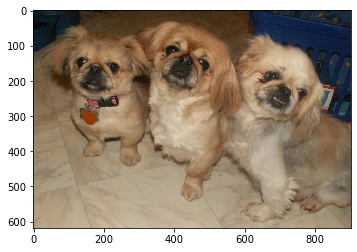

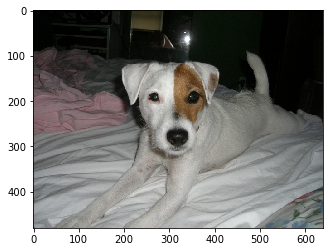

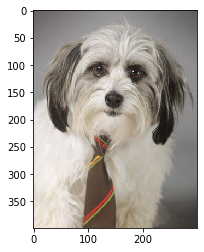

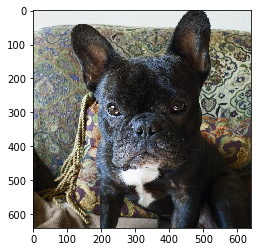

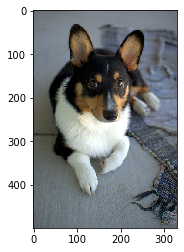

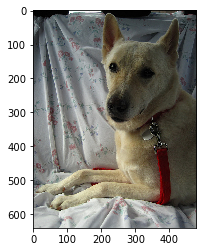

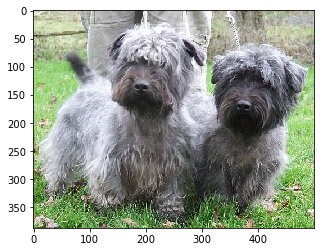

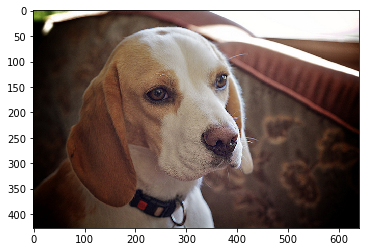

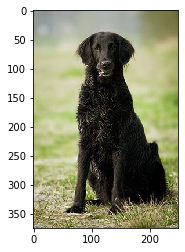

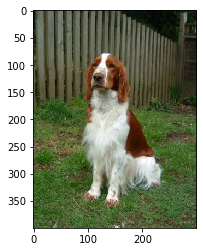

In [19]:
#import Image
indices = np.random.randint(0, len(dog_files), 10)

for idx in indices:
    image = Image.open(dog_files[idx])
    fig = plt.figure()
    plt.imshow(image)

### Look at transformed images
see if the transformations we applied (rotation, translation, etc..) are not too disturbing, it shouldn't be we cannot recognize the dogs ourselves anymore

In [20]:
# helper function to un-normalize and display an image
def imshow(img):
    plt.imshow(np.transpose(img, (1, 2, 0)))  # convert from Tensor image

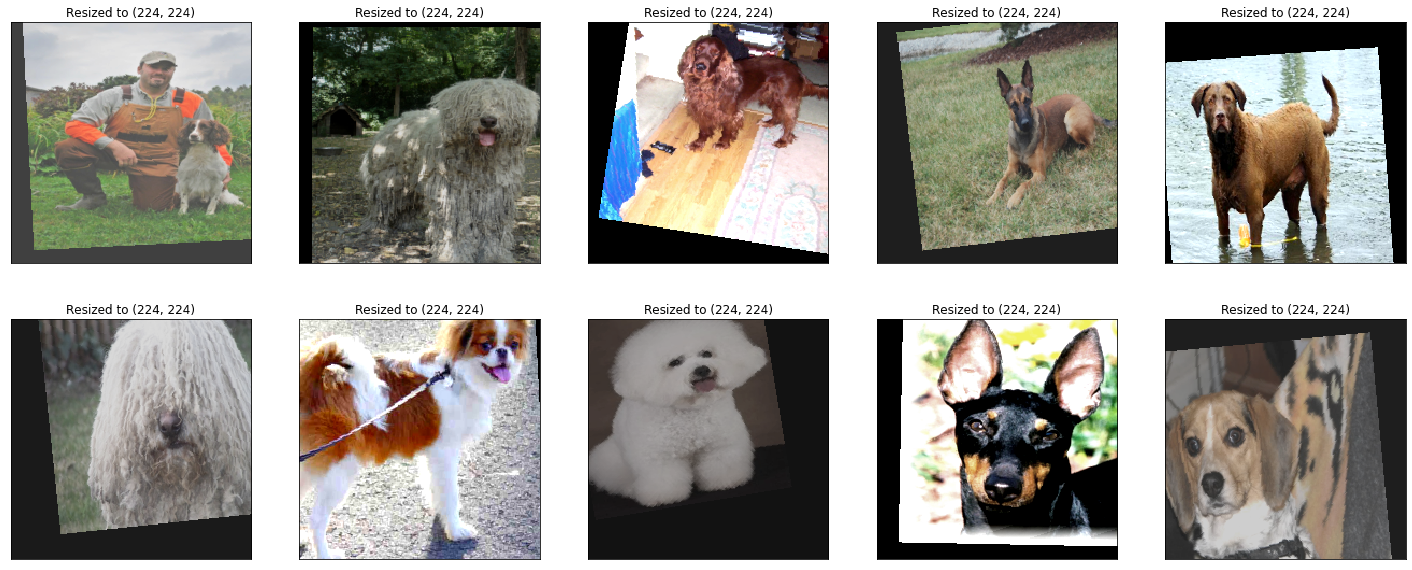

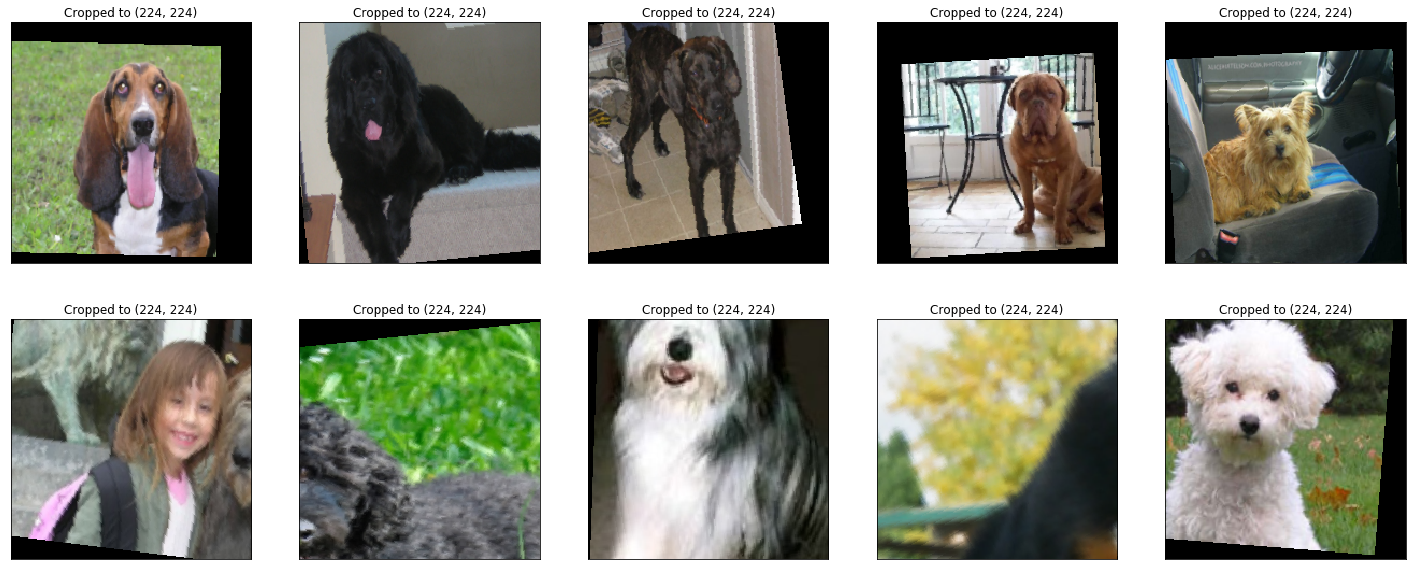

In [21]:
# obtain one batch of training images
dataiter_cr = iter(train_loader_crop)
dataiter = iter(train_loader_scratch)

images, labels = dataiter_cr.next()
images_res, labels_res = dataiter.next()


#### RESIZED IMAGES
fig = plt.figure(figsize=(25, 10))
for idx in np.arange(10):
    # resized images
    image = un_norm(images_res[idx])
    image = image.numpy()    

    # show images
    ax = fig.add_subplot(2, 10/2, idx+1, xticks=[], yticks=[])
    imshow(image)
    ax.set_title('Resized to (224, 224)')


#### CROPPED IMAGES
fig = plt.figure(figsize=(25, 10))
for idx in np.arange(10):
    # cropped images
    image = un_norm(images[idx])
    image = image.numpy()
    #plt.imshow(image)

    # show images
    ax = fig.add_subplot(2, 10/2, idx+1, xticks=[], yticks=[])
    imshow(image)
    ax.set_title('Cropped to (224, 224)')


**Motivate chosen procedure for preprocessing data**:

I had originally cropped the images to 224x224 pixel images, which is what is required for vgg16. Then I noticed that a lot of my dogs were missing their faces due to the cropping (e.g. of a lot of the pictures were quite tall compared to wide, then the top part of the picture (i.e. the head) can easily be cut off). I then decided to resize the images to 224x224 rather than cropping. 

I included some rotations, translations and colour jitter. The colour jitter might be useful because, though a lot of information is in the colours of the dogs, some breeds occur in different colours (like labradors, as also noted above) and it might be good to not depend on colour too much. Also, us humans can still recognize a german shepherd even if its colours are a big weird, so the neural network should be able to do this too.

I included horizontal flips, but no vertical flips as the vertical ones seem a bit unrealistic (maybe the pose of the dog gives information on what kind of dog it is (some dogs tend to sit up really straight, others don't), and this is harder to find when some images are upside down?

###  Model Architecture

Here we create our CNN from scratch. The chosen architecture was the result of some trial and error.

In [22]:
num_classes = 133

# define the CNN architecture
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        ## layers of a CNN
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.conv1_bn = nn.BatchNorm2d(16)
        
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.conv2_bn = nn.BatchNorm2d(32)

        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3_bn = nn.BatchNorm2d(64)
        
        self.conv4 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv4_bn = nn.BatchNorm2d(128)
        
        self.conv5 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.conv5_bn = nn.BatchNorm2d(256)
        
        # fully connected layers
        self.fc1 = nn.Linear(256*7*7,  1000)
        self.fc2 = nn.Linear(1000, 500)      
        self.fc3 = nn.Linear(500, num_classes)

        self.dropout = nn.Dropout(0.2)
        self.pool = nn.MaxPool2d(2, 2)
        
    
    def forward(self, x):
        ## Define forward behavior
        x = self.conv1_bn(self.pool(F.relu(self.conv1(x)))) #3x224x224 ---> 16x112x112
        
        x = self.conv2_bn(self.pool(F.relu(self.conv2(x)))) #16x112x112 ---> 32x56x56
        x = self.conv3_bn(self.pool(F.relu(self.conv3(x)))) #32x56x56 ---> 64x28x28
        x = self.conv4_bn(self.pool(F.relu(self.conv4(x)))) #64x28x28 ---> 128x14x14
        x = self.conv5_bn(self.pool(F.relu(self.conv5(x)))) #128x14x14 ---> 256x7x7
        
        # fully connected layers
        x = x.view(-1, 256*7*7)  
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        
        x = self.fc3(x)
          
        return x

# instantiate the CNN
model_scratch = Net()

# move tensors to GPU if CUDA is available
if use_cuda:
    model_scratch.cuda()

__Motivation for CNN architecture__ 

To be honest, I had to try quite a few architectures before I managed to get above 10% accuracy. Initially I had constructed my model such that the first few layers were the same as those of the vgg16 model, meaning that my first convolution layer had an output size of 64. This didn't work very well and eventually I increased the number of filters more slowly. 

In the end five convolutional layers worked better than 4, and also I reduced the output size of my first fully connected layer (originally I had set it at 4000 but that did not work well). 

I also changed changed the batch-size a bunch of times, from 50 to 32 to 10 to 25. 

### Specify Loss Function and Optimizer


In [23]:
# select loss function
criterion_scratch = nn.CrossEntropyLoss()

# select optimizer
optimizer_scratch = optim.Adam(model_scratch.parameters(), lr = 0.001)

### Train and load the best model

Below is a function to train the models. By keeping track of the validation loss, we only save the model if it performed better than our previous best model. 

I ran the model on a gpu for 90 epochs, and here I skip the training and load my earlier-trained model.

In [24]:
def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path):
    """
    Return a trained model
    :param n_epochs: int, number of epochs to train for
    :param loaders: dict, pytorch data loaders, should have keys "train", "test" and "valid", with pytorch
                    loaders as values
    :param model: an instance of our CNN class
    :param optimizer: a pytorch optimizer
    :param criterion: a pytorch loss function
    :param use_cuda: boolean, if True use GPU to train
    :param save_path: string, path where to save best model.
    :return: The trained model. The best model is saved at save_path.
    """
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf 
    
    for epoch in range(1, n_epochs+1):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        
        ###################
        # train the model #
        ###################
        model.train()
        for batch_idx, (data, target) in enumerate(loaders['train']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            
            # the model output
            output = model(data)
            
            # reset gradients
            optimizer.zero_grad()
            
            # loss and backward pass
            loss = criterion(output, target)
            loss.backward()
            
            # update weights
            optimizer.step()
            
            # keep track of loss
            train_loss = train_loss + ((1.0 / (batch_idx + 1)) * (loss.data - train_loss))
            
            
        ######################    
        # validate the model #
        ######################
        model.eval()
        for batch_idx, (data, target) in enumerate(loaders['valid']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            ## update the average validation loss
            output = model(data)
            loss = criterion(output, target)
            
            valid_loss = valid_loss + ((1.0 / (batch_idx + 1)) * (loss.data - valid_loss))
            
        # print training/validation statistics 
        print(f"\tEpoch: {epoch} \tTraining Loss: {train_loss:.6f} \tValidation Loss: {valid_loss:.6f}")
        
        ## save the model if validation loss has decreased
        if valid_loss <= valid_loss_min:
            print(f"\tValidation loss decreased ({valid_loss_min:.6f} --> {valid_loss:.6f}).  Saving model ...")
            torch.save(model.state_dict(), save_path)
            valid_loss_min = valid_loss
        
    # return trained model
    return model

In [ ]:
# train the model
model_scratch = train(3, loaders_scratch, model_scratch, optimizer_scratch, 
                      criterion_scratch, use_cuda, f'../models/model_scratch_{n_epochs}.pt')

torch.cuda.empty_cache()

In [25]:
# load the model that got the best validation accuracy
n_epochs = 90
model_scratch.load_state_dict(torch.load(f"../models/model_scratch_{n_epochs}.pt", map_location=lambda storage, loc: storage,))

<All keys matched successfully>

### Test the Model

Here we test out the model on some dog images, we print the test loss and accuracy.

In [26]:
def test(loaders, model, criterion, use_cuda):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    model.eval()
    for batch_idx, (data, target) in enumerate(loaders['test']):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
            
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        
        # calculate the loss
        loss = criterion(output, target)
        
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
        
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
    print(f'Test Loss: {test_loss:.6f}\n')

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (100. * correct / total, correct, total))

I ran the model for about 90 epochs, and I got 47% accuracy, which seems very reasonable (given that random chance should only give us 0.75% accuracy (given there are 133 classes, ignoring class imbalances)). 

In [27]:
# call test function    
test(loaders_scratch, model_scratch, criterion_scratch, use_cuda)

Test Loss: 1.946199


Test Accuracy: 47% (395/836)


# Create a CNN using transfer learning

We'll now use transfer learning to create a CNN that can identify dog breed from images. 

### Model Architecture

I took the very last layer of the VGG16 model and replaced it with a new fully connected layer with 133 outputs (as we have 133 classes). This is reasonable because the dog-breed images are not that different from the images the vgg16 model was trained on (some of the classes it was predicting were dogs as well). The weights in the earlier layers were frozen (as they are used for detection of e.g. corners and lines, etc.. ) and the weights in all the fully connected layers were re-trained. I got 86% percent accuracy by just removing the last layers and training for 70 epochs, which seems pretty good.

In [28]:
import torchvision.models as models
import torch.nn as nn

in_old = VGG16.classifier[6].in_features
print(VGG16.classifier[6].out_features) 
print(in_old) 

# Freeze training for all "features" layers
for param in VGG16.features.parameters():
    param.requires_grad = False
    
    
VGG16.classifier[6] = nn.Linear(in_old, 133)
model_transfer = VGG16

if use_cuda:
    model_transfer = model_transfer.cuda()

1000
4096


### Specify Loss Function and Optimizer


In [29]:
criterion_transfer = nn.CrossEntropyLoss()
optimizer_transfer = optim.SGD(model_transfer.classifier.parameters(), lr=0.001)

### Train and test the model

Again, I trained the model for 70 epochs using a GPU, so I just load in the trained model. But of course it can be trained by running the cell below. 


In [ ]:
# train the model
n_epochs = 10
model_transfer = train(n_epochs, 
                       loaders_transfer, 
                       model_transfer, 
                       optimizer_transfer, 
                       criterion_transfer, 
                       use_cuda, 
                       f'../models/model_transfer_{n_epochs}.pt')

Epoch: 1 	Training Loss: 4.207962 	Validation Loss: 3.016259
Validation loss decreased (inf --> 3.016259).  Saving model ...
Epoch: 2 	Training Loss: 2.490624 	Validation Loss: 1.434908
Validation loss decreased (3.016259 --> 1.434908).  Saving model ...
Epoch: 3 	Training Loss: 1.584643 	Validation Loss: 0.918020
Validation loss decreased (1.434908 --> 0.918020).  Saving model ...
Epoch: 4 	Training Loss: 1.229971 	Validation Loss: 0.735556
Validation loss decreased (0.918020 --> 0.735556).  Saving model ...
Epoch: 5 	Training Loss: 1.052936 	Validation Loss: 0.652286
Validation loss decreased (0.735556 --> 0.652286).  Saving model ...
Epoch: 6 	Training Loss: 0.967044 	Validation Loss: 0.603410
Validation loss decreased (0.652286 --> 0.603410).  Saving model ...
Epoch: 7 	Training Loss: 0.891680 	Validation Loss: 0.565055
Validation loss decreased (0.603410 --> 0.565055).  Saving model ...
Epoch: 8 	Training Loss: 0.827843 	Validation Loss: 0.551315
Validation loss decreased (0.56505

In [30]:
# load the model that got the best validation accuracy (uncomment the line below)
model_transfer.load_state_dict(torch.load('../models/model_transfer_70.pt', map_location=lambda storage, loc: storage,))

<All keys matched successfully>

### Test the Model

Here we test the model using the test function defined earlier

In [33]:
test(loaders_transfer, model_transfer, criterion_transfer, use_cuda)

Test Loss: 0.471555


Test Accuracy: 86% (723/836)


## Predict some dogs with our transfer model

Here we use the function `create_prediction_fig` in `src/models/predict_model`, which 
* uses the supplied model to predict the most likely class of the supplied image
* plots a figure with
    * the supplied image itself
    * a bar plot of the top five classes with highest probability
    * an image of the top dog with highest probability

In [38]:
test_dogs = np.array(glob("../data/raw/dogImages/test/*/*"))
random.shuffle(test_dogs)
test_dogs = test_dogs[:10]

Predicting for dog Greyhound


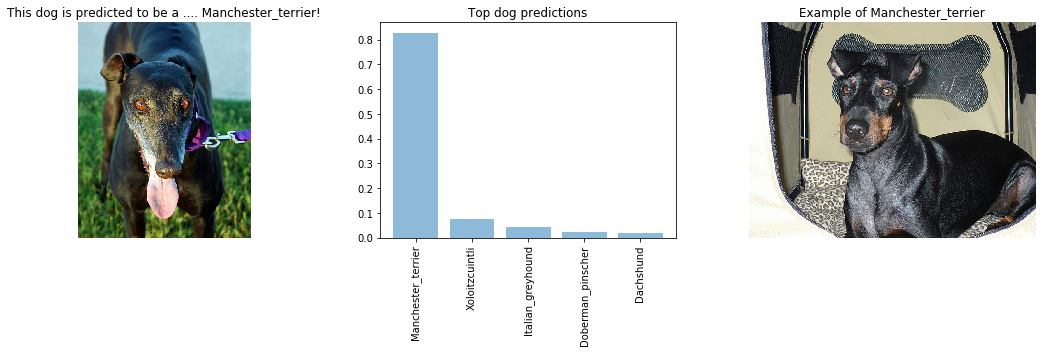

Predicting for dog German_wirehaired_pointer


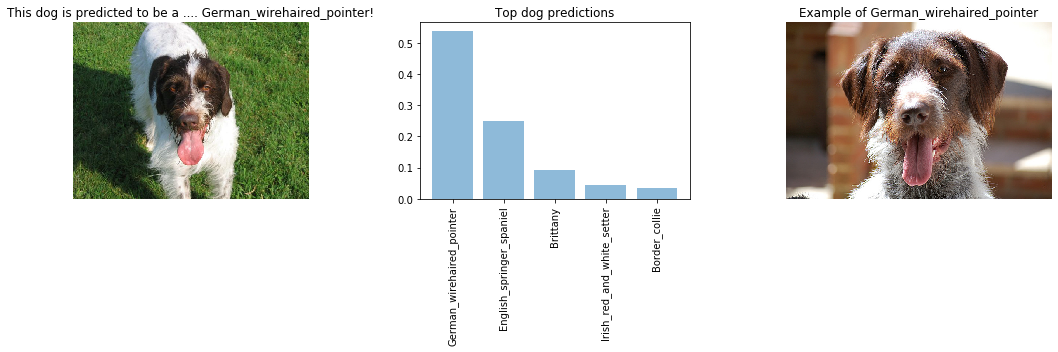

Predicting for dog Brussels_griffon


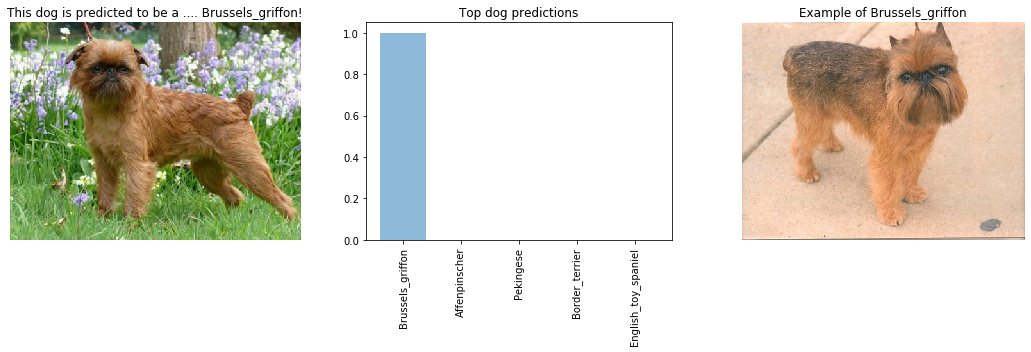

Predicting for dog Cavalier_king_charles_spaniel


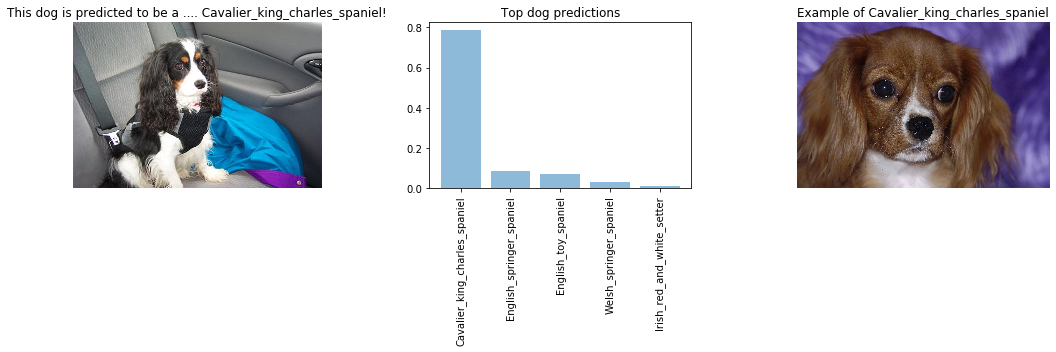

Predicting for dog Golden_retriever


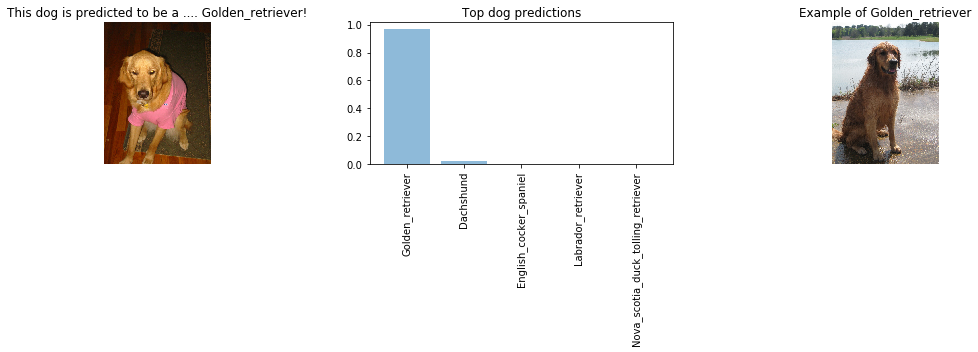

Predicting for dog Belgian_sheepdog


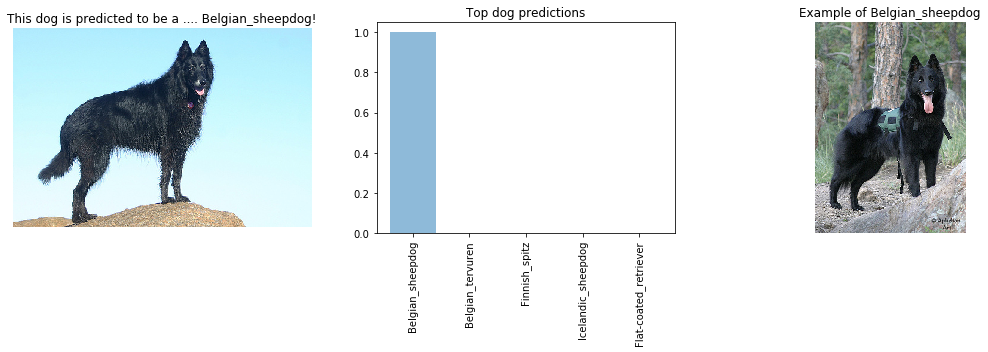

Predicting for dog Bloodhound


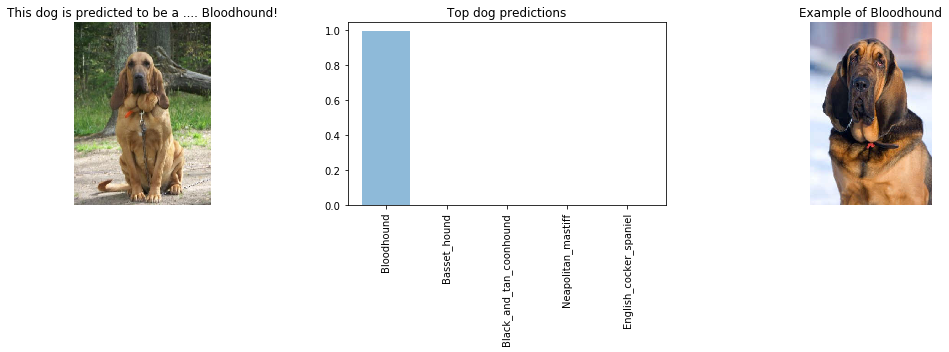

Predicting for dog Anatolian_shepherd_dog


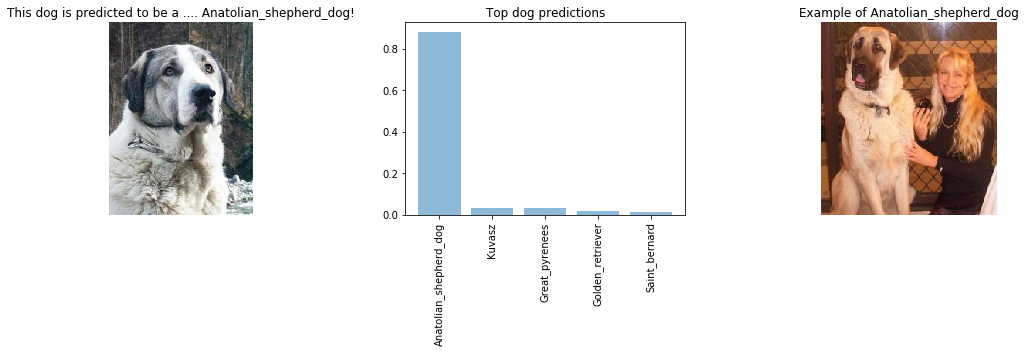

Predicting for dog Greater_swiss_mountain_dog


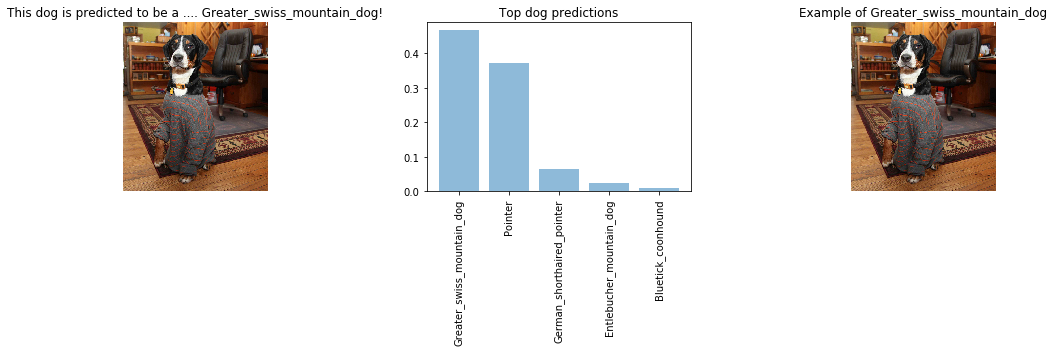

Predicting for dog Pekingese


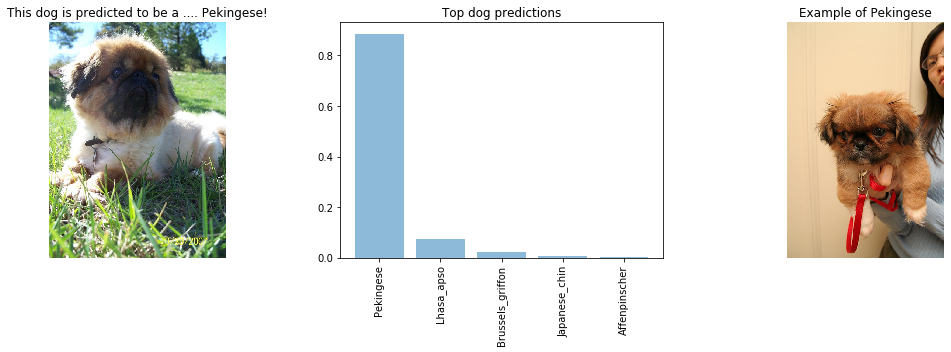

In [41]:
for dog in test_dogs:
    actual_dog = dog.split('\\')[-1][:-10]
    print(f"Predicting for dog {actual_dog}")
    predict_model.create_prediction_fig(dog, model_transfer, breeds, save_image=False,
                                        show_image=True, path_dog_files="../data/raw/dogImages/*/*/*")

## Predict closest dog breeds for humans

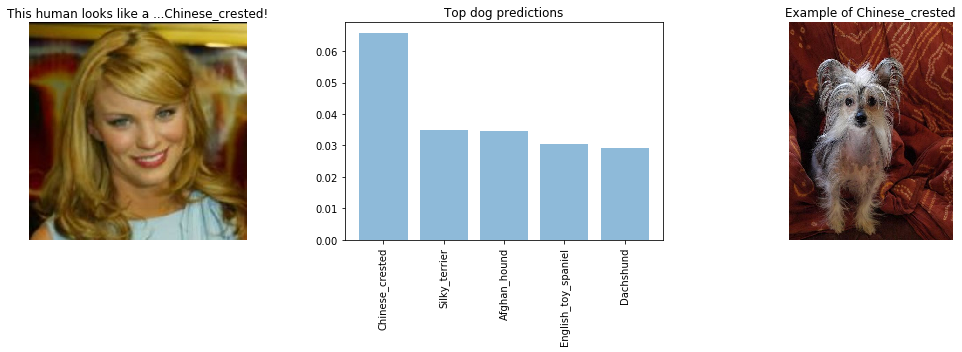

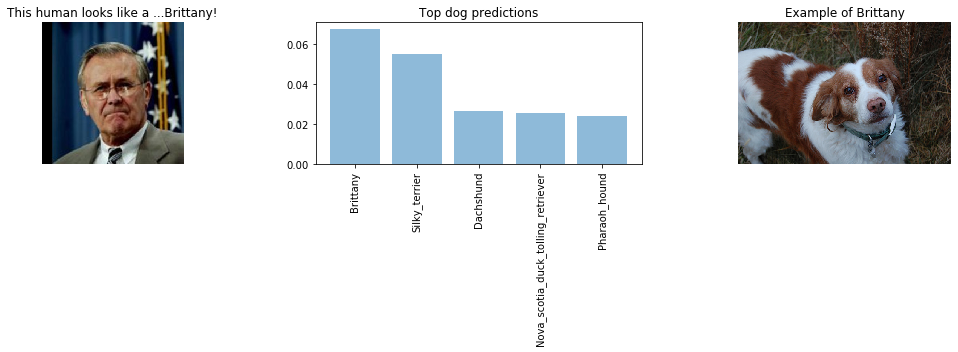

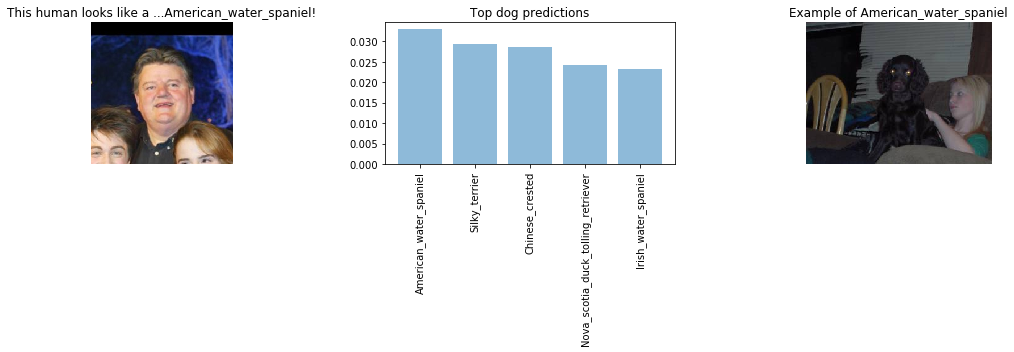

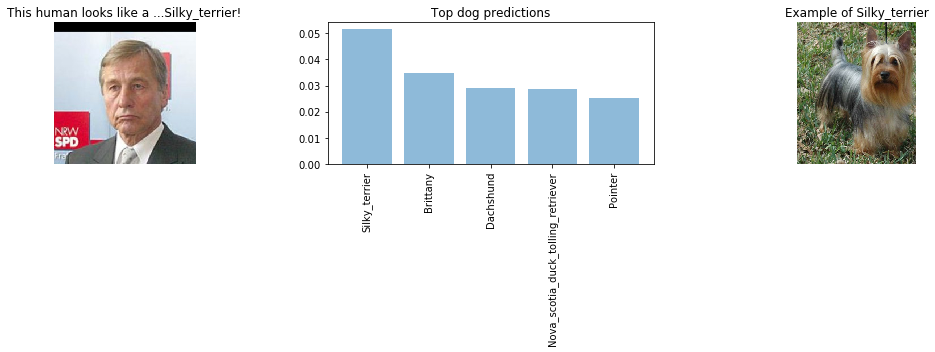

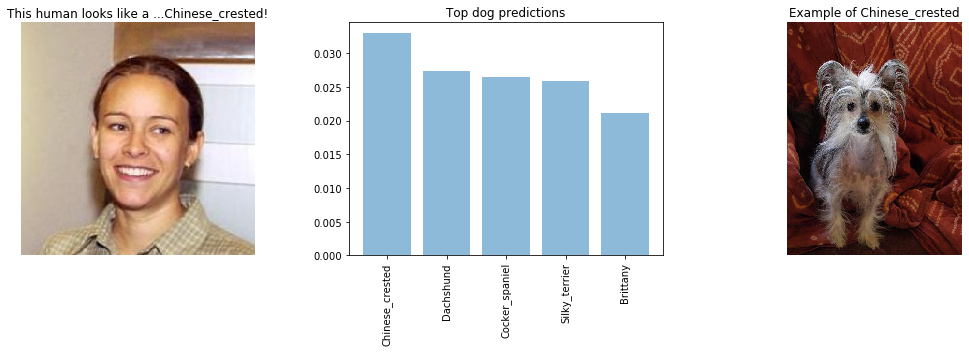

In [42]:
for human in human_files[:5]:
    predict_model.create_prediction_fig(human, model_transfer, breeds, save_image=False,
                                        show_image=True, path_dog_files="../data/raw/dogImages/*/*/*")